In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/guided_grounded_instructpix2pix/'

In [ ]:
!python -m pip install -e GroundingDINO

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

In [ ]:
!pip install segment-anything

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
!pip install transformers torch peft tqdm numpy scikit-learn

In [ ]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
!cd GroundingDINO

In [ ]:
import math
import torch
import os
from PIL import Image
from pathlib import Path

from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from diffusers import DDIMScheduler, DDIMInverseScheduler
from pipeline_stable_diffusion_grounded_instruct_pix2pix import StableDiffusionInstructPix2PixPipeline

from external_mask_extractor_improved import ExternalMaskExtractor
from transformers import logging
logging.set_verbosity_error()

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
def load_pil_image(image_path, resolution=512):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    factor = resolution / max(width, height)
    factor = math.ceil(min(width, height) * factor / 64) * 64 / min(width, height)
    width = int((width * factor) // 64) * 64
    height = int((height * factor) // 64) * 64
    image = ImageOps.fit(image, (width, height), method=Image.Resampling.LANCZOS)
    return image

In [ ]:
device = 'cuda:0'

# pipeline
num_timesteps = 100
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained("timbrooks/instruct-pix2pix",
                                                                  torch_dtype=torch.float16,
                                                                  safety_checker=None).to(device)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config, set_alpha_to_zero=False)

pipeline.scheduler.set_timesteps(num_timesteps)
pipeline.inverse_scheduler.set_timesteps(num_timesteps)

In [ ]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# extractor = ExternalMaskExtractor(device=device)

# Define model paths here
SAM_PATH = '/content/drive/MyDrive/SAM/sam_vit_h_4b8939.pth'
TARGET_PREDICTOR_PATH = "/content/drive/MyDrive/guided_grounded_instructpix2pix/models/target_finder_bert_lora_model"
SIZE_PREDICTOR_PATHS = ["/content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/standardSmoothL1_model.pth",
                        "/content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/CombLoss_model.pth"]

device = 'cuda:0'
extractor = ExternalMaskExtractor(
    device=device,
    target_predictor_model_path=TARGET_PREDICTOR_PATH,
    size_predictor_model_path=SIZE_PREDICTOR_PATHS,
    sam_path=SAM_PATH
)

def inference(pipeline, image_pil, instruction, image_guidance_scale, text_guidance_scale, seed, blending_range):
    final_mask, first_target_phrase, second_target_phrase, directional_phrase, final_sentence, predicted_size_mask = extractor.get_external_mask(image_pil, instruction, verbose=True)

    inv_results = pipeline.invert(final_sentence, image_pil, num_inference_steps=num_timesteps, inv_range=blending_range)
    generator = torch.Generator(device).manual_seed(seed) if seed is not None else torch.Generator(device)
    edited_image = pipeline(final_sentence, src_mask=final_mask, image=image_pil,
                            guidance_scale=text_guidance_scale, image_guidance_scale=image_guidance_scale,
                            num_inference_steps=num_timesteps, generator=generator).images[0]
    return edited_image, final_mask, predicted_size_mask

In [ ]:
verbose = False

def edit_image(
    pipeline,
    image_path,
    edit_instruction,
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep=1000,
    end_blending_at_tstep=1,
    verbose=False
):
    blending_range = [start_blending_at_tstep, end_blending_at_tstep]

    image = load_pil_image(image_path)

    edited_image, final_mask, predicted_size_mask = inference(
        pipeline, image, edit_instruction,
        image_guidance_scale=image_guidance_scale,
        text_guidance_scale=guidance_scale,
        seed=seed,
        blending_range=blending_range
    )

##############################################################
    # Extract original image filename without extension
    original_filename = Path(image_path).stem

    # Define output directories
    edited_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/ggip2p_edited_images')
    mask_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/ggip2p_edited_masks')

    # Create directories if they don't exist
    edited_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    # Save edited image
    edited_image_path = edited_dir / f'{original_filename}.jpg'
    edited_image.save(edited_image_path)

    # Convert masks to PIL Images if needed
    if not isinstance(final_mask, Image.Image):
        final_mask = Image.fromarray(final_mask.astype('uint8'))
    if not isinstance(predicted_size_mask, Image.Image):
        predicted_size_mask = Image.fromarray((predicted_size_mask.cpu().numpy() * 255).astype('uint8'))

    # Save masks
    final_mask_path = mask_dir / f'{original_filename}_final_mask.png'
    predicted_size_mask_path = mask_dir / f'{original_filename}_size_mask.png'

    final_mask.save(final_mask_path)
    predicted_size_mask.save(predicted_size_mask_path)

##############################################################

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(edited_image)
    axes[1].set_title('Edited Image')
    axes[1].axis('off')

    axes[2].imshow(final_mask)
    axes[2].set_title('Final Mask')
    axes[2].axis('off')

    axes[3].imshow(predicted_size_mask, cmap='gray')
    axes[3].set_title('Predicted Size Mask')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

Prompt make the horse on the left side of gray horse to a white horse
First Target: horse
First Target Phrase: gray horse
Second Target: horse
Second Target Phrase: the horse
Directional Word: left
Directional Phrase: on the left side of
Final Sentence: make the horse to a white horse
Matched direction: left
Direction_is_used:  False


Shape of Boxes for gray horse  :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([1, 4])
horse  is_singular? -->  True
boxes_xyxy1:  tensor([[291.5685,  62.4680, 401.0441, 383.8920]])
Shape of Boxes for the horse  :  torch.Size([3, 4])
Shape of Boxes for horse  (without the) :  torch.Size([4, 4])
ALL Boxes xyxy1 Shape:  torch.Size([7, 4])
horse  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([4, 4])
Direction_is_used?  False
Apply_relative_directional_logic left
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[136.4570,  42.2834, 269.4107, 383.8110]])


  0%|          | 0/100 [00:00<?, ?it/s]

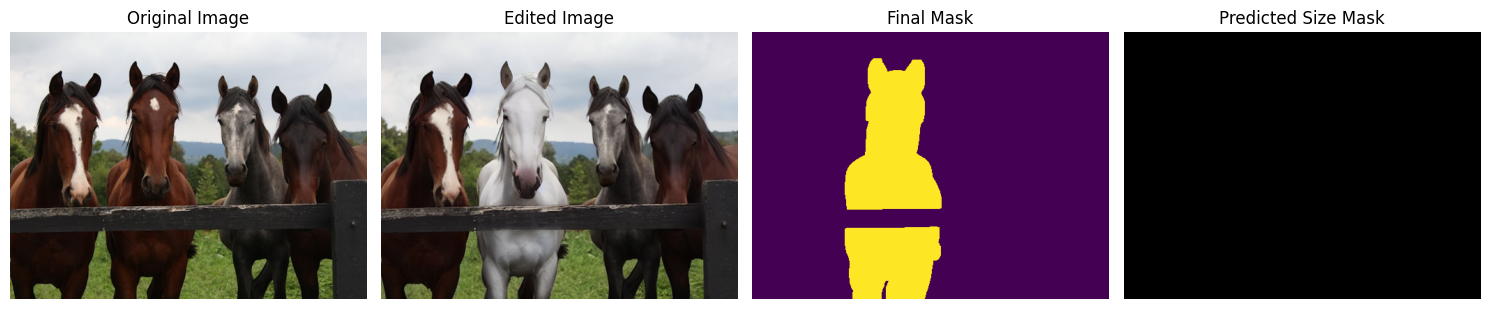

In [ ]:
edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/guided_grounded_instructpix2pix/imgs/some_test_image/lucia-macedo-xXLT52bAzkk-unsplash.jpg',
    edit_instruction = 'make the horse on the left side of gray horse to a white horse',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 100
)

Prompt add a beautiful butterfly on the top of the candle
First Target: candle
First Target Phrase: the candle
Second Target: No second target found
Second Target Phrase: 
Directional Word: top
Directional Phrase: on the top of
Final Sentence: add a beautiful butterfly
Matched direction: top
Direction_is_used:  False


Shape of Boxes for the candle  :  torch.Size([2, 4])
Shape of Boxes for candle  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
candle  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[196.6803, 215.3564, 206.9166, 281.7443]])
Using size predictor with direction: top
remain noun phrase: beautiful butterfly
Predicted Ratio: [8.158843  1.1079975]
Predicted Size in 512 (w, h): 83 74
Padding: (0, 0, 64, 64)
Predicted Real Size (w, h): 83 74


  0%|          | 0/100 [00:00<?, ?it/s]

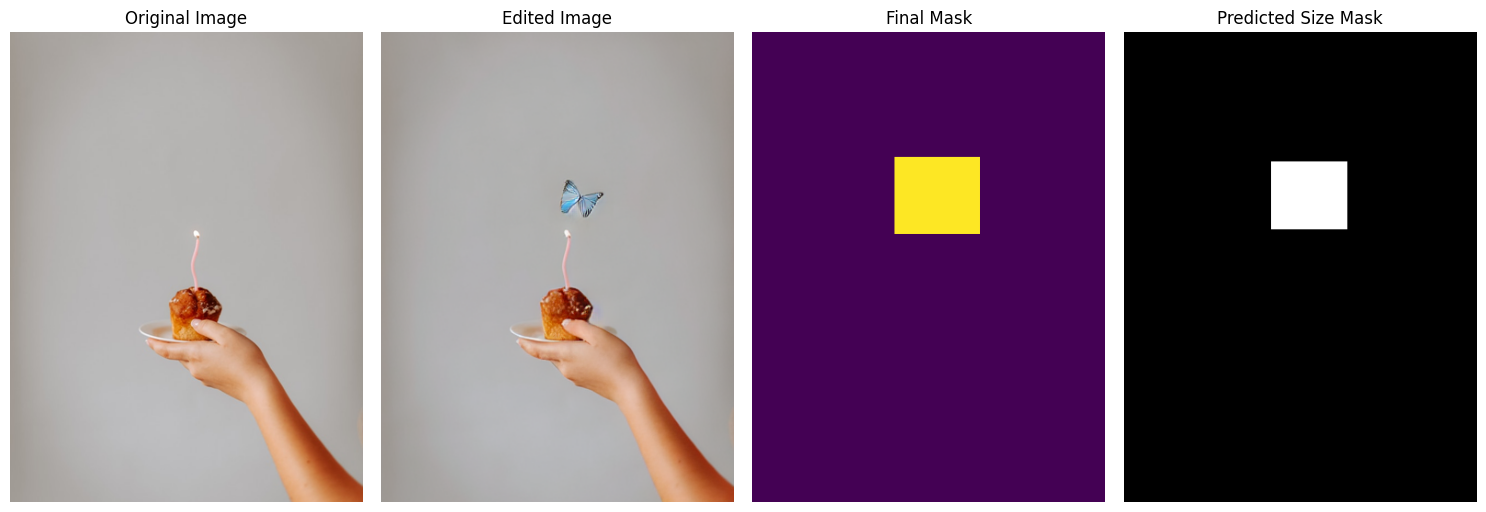

In [ ]:
edit_image(
    pipeline=pipeline,
    image_path = "/content/drive/MyDrive/guided_grounded_instructpix2pix/imgs/some_test_image/kateryna-hliznitsova-zKvV5yxVHfI-unsplash_big.jpg",
    edit_instruction = "add a beautiful butterfly on the top of the candle",
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 1000
)